# 8강 정형데이터 분류 베이스라인 모델 3 피처 중요도

- 세번째 베이스라인 모델에서 LightGBM 외에 XGBoost, CatBoost 모델링을 추가 구현해보고 각 모델의 피처 중요도를 계산하여 그려보기

## Function 정의

- seed_everything() : seed 고정 함수
- generate_label() : label 생성 함수
- print_score() : 평가지표 출력 함수
- feature_preprocessing() : 데이터 전처리 함수(label encoding, 결측치 처리)
- feature_engineering1() : 피처 엔지니어링 함수
- make_lgb_oof_prediction() : LightGBM cross validation out of fold train/predict 함수
- make_xgb_oof_prediction() : XGBoost cross validation out of fold train/predict 함수
- make_cat_oof_prediction() : CatBoost cross validation out of fold train/predict 함수
- plot_feature_importances() : 피처 중요도 플롯 함수

## Library Import

In [2]:
# Suppress warnings 
import warnings
warnings.filterwarnings('ignore')

import os, sys, gc, warnings, random

import datetime
import dateutil.relativedelta

# Data manipulation
import pandas as pd 
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Machine learning
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.impute import SimpleImputer
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, precision_recall_curve, roc_curve
from sklearn.model_selection import train_test_split, cross_val_score, KFold, StratifiedKFold, GroupKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import MinMaxScaler


import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostClassifier, Pool

from tqdm.notebook import trange, tqdm

from IPython.display import display

%matplotlib inline

pd.options.display.max_rows = 10000
pd.options.display.max_columns = 1000
pd.options.display.max_colwidth = 1000

## Fix Seed 함수 정의

In [3]:
def seed_everything(seed=0):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
SEED = 42
seed_everything(SEED)

## 레이블 생성 함수 정의

- 레이블 생성 함수는 연월을 인자로 받아서 고객 아이디별로 총 구매액이 인자로 받는 구매액 임계값을 넘는지 여부를 바이너리 레이블로 생성하는 함수

In [4]:
TOTAL_THRES = 300

'''
    입력인자로 받는 year_month에 대해 고객 ID별로 총 구매액이
    구매액 임계값을 넘는지 여부의 binary label을 생성하는 함수
'''
def generate_label(df, year_month, total_thres=TOTAL_THRES, print_log=False):
    df = df.copy()
    
    # year_month에 해당하는 label 데이터 생성
    df['year_month'] = df['order_date'].dt.strftime('%Y-%m')
    df.reset_index(drop=True, inplace=True)

    # year_month 이전 월의 고객 ID 추출
    cust = df[df['year_month']<year_month]['customer_id'].unique()
    # year_month에 해당하는 데이터 선택
    df = df[df['year_month']==year_month]
    
    # label 데이터프레임 생성
    label = pd.DataFrame({'customer_id':cust})
    label['year_month'] = year_month
    
    # year_month에 해당하는 고객 ID의 구매액의 합 계산
    grped = df.groupby(['customer_id','year_month'], as_index=False)[['total']].sum()
    
    # label 데이터프레임과 merge하고 구매액 임계값을 넘었는지 여부로 label 생성
    label = label.merge(grped, on=['customer_id','year_month'], how='left')
    label['total'].fillna(0.0, inplace=True)
    label['label'] = (label['total'] > total_thres).astype(int)

    # 고객 ID로 정렬
    label = label.sort_values('customer_id').reset_index(drop=True)
    if print_log: print(f'{year_month} - final label shape: {label.shape}')
    
    return label

## 평가지표 출력 함수 정의

In [5]:
def print_score(label, pred, prob_thres=0.5):
    print('Precision: {:.5f}'.format(precision_score(label, pred>prob_thres)))
    print('Recall: {:.5f}'.format(recall_score(label, pred>prob_thres)))
    print('F1 Score: {:.5f}'.format(f1_score(label, pred>prob_thres)))
    print('ROC AUC Score: {:.5f}'.format(roc_auc_score(label, pred)))

## 데이터 전처리 함수 정의
- 범주형 변수 레이블 인코딩
- 결측치 중위값으로 채움

In [6]:
def feature_preprocessing(train, test, features, do_imputing=True):
    x_tr = train.copy()
    x_te = test.copy()
    
    # 범주형 피처 이름을 저장할 변수
    cate_cols = []

    # 레이블 인코딩
    for f in features:
        if x_tr[f].dtype.name == 'object': # 데이터 타입이 object(str)이면 레이블 인코딩
            cate_cols.append(f)
            le = LabelEncoder()
            # train + test 데이터를 합쳐서 레이블 인코딩 함수에 fit
            le.fit(list(x_tr[f].values) + list(x_te[f].values))
            
            # train 데이터 레이블 인코딩 변환 수행
            x_tr[f] = le.transform(list(x_tr[f].values))
            
            # test 데이터 레이블 인코딩 변환 수행
            x_te[f] = le.transform(list(x_te[f].values))

    print('categorical feature:', cate_cols)

    if do_imputing:
        # 중위값으로 결측치 채우기
        imputer = SimpleImputer(strategy='median')

        x_tr[features] = imputer.fit_transform(x_tr[features])
        x_te[features] = imputer.transform(x_te[features])
    
    return x_tr, x_te

## 피처 엔지니어링 함수 정의
- Pandas groupby aggregation 함수를 사용한 피처 엔지니어링

In [7]:
def feature_engineering1(df, year_month):
    df = df.copy()
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_func)

        # 멀티 레벨 컬럼을 사용하기 쉽게 1 레벨 컬럼명으로 변경
        new_cols = []
        for col in train_agg.columns.levels[0]:
            for stat in train_agg.columns.levels[1]:
                new_cols.append(f'{col}-{stat}')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_func)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

In [8]:
def feature_engineering2(df, year_month):
    df = df.copy()
    
    # customer_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_cust_id'] = df.groupby(['customer_id'])['total'].cumsum()
    df['cumsum_quantity_by_cust_id'] = df.groupby(['customer_id'])['quantity'].cumsum()
    df['cumsum_price_by_cust_id'] = df.groupby(['customer_id'])['price'].cumsum()

    # product_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_prod_id'] = df.groupby(['product_id'])['total'].cumsum()
    df['cumsum_quantity_by_prod_id'] = df.groupby(['product_id'])['quantity'].cumsum()
    df['cumsum_price_by_prod_id'] = df.groupby(['product_id'])['price'].cumsum()
    
    # order_id 기준으로 pandas group by 후 total, quantity, price 누적합 계산
    df['cumsum_total_by_order_id'] = df.groupby(['order_id'])['total'].cumsum()
    df['cumsum_quantity_by_order_id'] = df.groupby(['order_id'])['quantity'].cumsum()
    df['cumsum_price_by_order_id'] = df.groupby(['order_id'])['price'].cumsum()    
    
    
    # year_month 이전 월 계산
    d = datetime.datetime.strptime(year_month, "%Y-%m")
    prev_ym = d - dateutil.relativedelta.relativedelta(months=1)
    prev_ym = prev_ym.strftime('%Y-%m')
    
    # train, test 데이터 선택
    train = df[df['order_date'] < prev_ym]
    test = df[df['order_date'] < year_month]
    
    # train, test 레이블 데이터 생성
    train_label = generate_label(df, prev_ym)[['customer_id','year_month','label']]
    test_label = generate_label(df, year_month)[['customer_id','year_month','label']]
    
    # group by aggregation 함수 선언
    agg_func = ['mean','max','min','sum','count','std','skew']
    agg_dict = {
        'quantity': agg_func,
        'price': agg_func,
        'total': agg_func,
        'cumsum_total_by_cust_id': agg_func,
        'cumsum_quantity_by_cust_id': agg_func,
        'cumsum_price_by_cust_id': agg_func,
        'cumsum_total_by_prod_id': agg_func,
        'cumsum_quantity_by_prod_id': agg_func,
        'cumsum_price_by_prod_id': agg_func,
        'cumsum_total_by_order_id': agg_func,
        'cumsum_quantity_by_order_id': agg_func,
        'cumsum_price_by_order_id': agg_func,
        'order_id': ['nunique'],
        'product_id': ['nunique'],
    }
    all_train_data = pd.DataFrame()
    
    for i, tr_ym in enumerate(train_label['year_month'].unique()):
        # group by aggretation 함수로 train 데이터 피처 생성
        train_agg = train.loc[train['order_date'] < tr_ym].groupby(['customer_id']).agg(agg_dict)

        new_cols = []
        for col in agg_dict.keys():
            for stat in agg_dict[col]:
                if type(stat) is str:
                    new_cols.append(f'{col}-{stat}')
                else:
                    new_cols.append(f'{col}-mode')

        train_agg.columns = new_cols
        train_agg.reset_index(inplace = True)
        
        train_agg['year_month'] = tr_ym
        
        all_train_data = all_train_data.append(train_agg)
    
    all_train_data = train_label.merge(all_train_data, on=['customer_id', 'year_month'], how='left')
    features = all_train_data.drop(columns=['customer_id', 'label', 'year_month']).columns
    
    # group by aggretation 함수로 test 데이터 피처 생성
    test_agg = test.groupby(['customer_id']).agg(agg_dict)
    test_agg.columns = new_cols
    
    test_data = test_label.merge(test_agg, on=['customer_id'], how='left')

    # train, test 데이터 전처리
    x_tr, x_te = feature_preprocessing(all_train_data, test_data, features)
    
    print('x_tr.shape', x_tr.shape, ', x_te.shape', x_te.shape)
    
    return x_tr, x_te, all_train_data['label'], features

## LightGBM cross validation out of fold train/predict 함수 정의

In [39]:
def make_lgb_oof_prediction(train, y, test, features, categorical_features='auto', model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')

        # LightGBM 데이터셋 선언
        dtrain = lgb.Dataset(x_tr, label=y_tr)
        dvalid = lgb.Dataset(x_val, label=y_val)
        
        # LightGBM 모델 훈련
        clf = lgb.train(
            model_params,
            dtrain,
            valid_sets=[dtrain, dvalid], # Validation 성능을 측정할 수 있도록 설정
            categorical_feature=categorical_features,
            verbose_eval=200
        )

        # Validation 데이터 예측
        val_preds = clf.predict(x_val)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(x_test) / folds
        
        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importance()

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## XGBoost cross validation out of fold train/predict 함수 정의

In [40]:
def make_xgb_oof_prediction(train, y, test, features, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # XGBoost 데이터셋 선언
        dtrain = xgb.DMatrix(x_tr, label=y_tr)
        dvalid = xgb.DMatrix(x_val, label=y_val)
        
        # XGBoost 모델 훈련
        clf = xgb.train(
            model_params,
            dtrain,
            num_boost_round=10000, # 트리 개수
            evals=[(dtrain, 'train'), (dvalid, 'valid')],  # Validation 성능을 측정할 수 있도록 설정
            verbose_eval=200,
            early_stopping_rounds=100
        )
        
        # Validation 데이터 예측
        val_preds = clf.predict(dvalid)
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict(xgb.DMatrix(x_test)) / folds

        # 폴드별 피처 중요도 저장
        fi_tmp = pd.DataFrame.from_records([clf.get_score()]).T.reset_index()
        fi_tmp.columns = ['feature',f'fold_{fold+1}']
        fi = pd.merge(fi, fi_tmp, on='feature')

        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## CatBoost cross validation out of fold train/predict 함수 정의

In [41]:
def make_cat_oof_prediction(train, y, test, features, categorical_features=None, model_params=None, folds=10):
    x_train = train[features]
    x_test = test[features]
    
    # 테스트 데이터 예측값을 저장할 변수
    test_preds = np.zeros(x_test.shape[0])
    
    # Out Of Fold Validation 예측 데이터를 저장할 변수
    y_oof = np.zeros(x_train.shape[0])
    
    # 폴드별 평균 Validation 스코어를 저장할 변수
    score = 0
    
    # 피처 중요도를 저장할 데이터 프레임 선언
    fi = pd.DataFrame()
    fi['feature'] = features
    
    # Stratified K Fold 선언
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=SEED)

    for fold, (tr_idx, val_idx) in enumerate(skf.split(x_train, y)):
        # train index, validation index로 train 데이터를 나눔
        x_tr, x_val = x_train.loc[tr_idx, features], x_train.loc[val_idx, features]
        y_tr, y_val = y[tr_idx], y[val_idx]
        
        
        print(f'fold: {fold+1}, x_tr.shape: {x_tr.shape}, x_val.shape: {x_val.shape}')
        
        # CatBoost 모델 훈련
        clf = CatBoostClassifier(**model_params)
        clf.fit(x_tr, y_tr,
                eval_set=(x_val, y_val), # Validation 성능을 측정할 수 있도록 설정
                cat_features=categorical_features,
                use_best_model=True,
                verbose=True)
        
        # Validation 데이터 예측
        val_preds = clf.predict_proba(x_val)[:,1]
        
        # Validation index에 예측값 저장 
        y_oof[val_idx] = val_preds
        
        # 폴드별 Validation 스코어 출력
        print(f"Fold {fold + 1} | AUC: {roc_auc_score(y_val, val_preds)}")
        print('-'*80)

        # score 변수에 폴드별 평균 Validation 스코어 저장
        score += roc_auc_score(y_val, val_preds) / folds
        
        # 테스트 데이터 예측하고 평균해서 저장
        test_preds += clf.predict_proba(x_test)[:,1] / folds

        # 폴드별 피처 중요도 저장
        fi[f'fold_{fold+1}'] = clf.feature_importances_
        
        del x_tr, x_val, y_tr, y_val
        gc.collect()
        
    print(f"\nMean AUC = {score}") # 폴드별 평균 Validation 스코어 출력
    print(f"OOF AUC = {roc_auc_score(y, y_oof)}") # Out Of Fold Validation 스코어 출력
        
    # 폴드별 피처 중요도 평균값 계산해서 저장
    fi_cols = [col for col in fi.columns if 'fold_' in col]
    fi['importance'] = fi[fi_cols].mean(axis=1)
    
    return y_oof, test_preds, fi

## 피처 중요도 플롯 함수 정의

In [42]:
def plot_feature_importances(df, n=20, color='blue', figsize=(12,8)):
    # 피처 중요도 순으로 내림차순 정렬
    df = df.sort_values('importance', ascending = False).reset_index(drop = True)
    
    # 피처 중요도 정규화 및 누적 중요도 계산
    df['importance_normalized'] = df['importance'] / df['importance'].sum()
    df['cumulative_importance'] = np.cumsum(df['importance_normalized'])
    
    plt.rcParams['font.size'] = 12
    plt.style.use('fivethirtyeight')
    # 피처 중요도 순으로 n개까지 바플롯으로 그리기
    df.loc[:n, :].plot.barh(y='importance_normalized', 
                            x='feature', color=color, 
                            edgecolor='k', figsize=figsize,
                            legend=False)

    plt.xlabel('Normalized Importance', size=18); plt.ylabel(''); 
    plt.title(f'Top {n} Most Important Features', size=18)
    plt.gca().invert_yaxis()
    
    return df

## Train 데이터 읽기
- 9개의 feature를 가진 780502개의 train data

In [13]:
data = pd.read_csv("../input/train.csv", parse_dates=["order_date"])
print(data.shape) # data shape 확인
data.head()

(780502, 9)


,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
0,489434,85048,15CM CHRISTMAS GLASS BALL 20 LIGHTS,12,2009-12-01 07:45:00,11.4675,13085,United Kingdom,137.61
1,489434,79323P,PINK CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
2,489434,79323W,WHITE CHERRY LIGHTS,12,2009-12-01 07:45:00,11.1375,13085,United Kingdom,133.65
3,489434,22041,"RECORD FRAME 7"" SINGLE SIZE",48,2009-12-01 07:45:00,3.4650,13085,United Kingdom,166.32
4,489434,21232,STRAWBERRY CERAMIC TRINKET BOX,24,2009-12-01 07:45:00,2.0625,13085,United Kingdom,49.50


## Pandas info() 함수로 데이터 타입 및 null 체크

In [14]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 780502 entries, 0 to 780501
Data columns (total 9 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   order_id     780502 non-null  object        
 1   product_id   780502 non-null  object        
 2   description  780502 non-null  object        
 3   quantity     780502 non-null  int64         
 4   order_date   780502 non-null  datetime64[ns]
 5   price        780502 non-null  float64       
 6   customer_id  780502 non-null  int64         
 7   country      780502 non-null  object        
 8   total        780502 non-null  float64       
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 53.6+ MB


## Pandas isna(), sum() 함수로 null 데이터 개수 체크

In [15]:
data.isna().sum()

order_id       0
product_id     0
description    0
quantity       0
order_date     0
price          0
customer_id    0
country        0
total          0
dtype: int64

## Pandas describe() 함수에 include='all' 인자 설정으로 수치형, 범주형 데이터 기본 통계량 확인

In [16]:
data.describe(include='all')

,order_id,product_id,description,quantity,order_date,price,customer_id,country,total
count,780502,780502,780502,780502.000000,780502,780502.000000,780502.000000,780502,780502.000000
unique,43955,4645,5297,NaN,40615,NaN,NaN,41,NaN
top,576339,85123A,WHITE HANGING HEART T-LIGHT HOLDER,NaN,2011-11-14 15:27:00,NaN,NaN,United Kingdom,NaN
freq,542,5096,5096,NaN,543,NaN,NaN,700317,NaN
first,NaN,NaN,NaN,NaN,2009-12-01 07:45:00,NaN,NaN,NaN,NaN
last,NaN,NaN,NaN,NaN,2011-11-30 17:42:00,NaN,NaN,NaN,NaN
mean,NaN,NaN,NaN,12.623307,NaN,6.140931,15313.393466,NaN,33.715373
std,NaN,NaN,NaN,143.906302,NaN,119.042266,1695.765797,NaN,274.207403
min,NaN,NaN,NaN,-74215.000000,NaN,0.000000,12346.000000,NaN,-127352.940000
25%,NaN,NaN,NaN,2.000000,NaN,2.062500,13963.000000,NaN,7.260000


## 2011년 11월 Label 데이터 생성

In [17]:
label_2011_11 = generate_label(data, '2011-11')['label']

## Label 데이터 분포 플롯

0    4534
1    1188
Name: label, dtype: int64

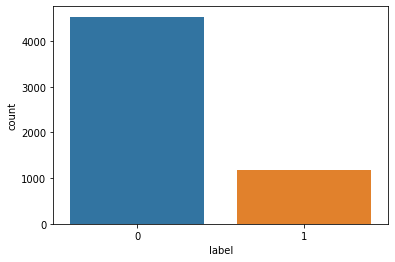

In [18]:
sns.countplot(label_2011_11);
label_2011_11.value_counts()

## LightGBM Hyperparameter 선언
- early stopping 기능을 사용하기 위해 n_estimators, early_stopping_rounds 설정

In [24]:
model_params = {
    'objective': 'binary', # 이진 분류
    'boosting_type': 'gbdt',
    'metric': 'auc', # 평가 지표 설정
    'feature_fraction': 0.8, # 피처 샘플링 비율
    'bagging_fraction': 0.8, # 데이터 샘플링 비율
    'bagging_freq': 1,
    'n_estimators': 10000, # 트리 개수
    'early_stopping_rounds': 100,
    'seed': SEED,
    'verbose': -1,
    'n_jobs': -1,    
}

In [78]:
all_train = pd.DataFrame()
all_y = pd.Series()
year_month = '2011-12'
data['year_month'] = data['order_date'].dt.strftime('%Y-%m')
data.reset_index(drop=True, inplace=True)


for ym in sorted(np.append(data["year_month"].unique(), [year_month], axis=0)):
    if ym == '2009-12' or ym == '2010-01':
        continue
    print(ym)
    train, test, y, train_features = feature_engineering2(data,ym)
    all_train = pd.concat([all_train,train])
    all_y = pd.concat([all_y,y])
    

2010-02
categorical feature: []
x_tr.shape (1045, 89) , x_te.shape (1439, 89)
2010-03
categorical feature: []
x_tr.shape (1439, 89) , x_te.shape (1802, 89)
2010-04
categorical feature: []
x_tr.shape (1802, 89) , x_te.shape (2238, 89)
2010-05
categorical feature: []
x_tr.shape (2238, 89) , x_te.shape (2529, 89)
2010-06
categorical feature: []
x_tr.shape (2529, 89) , x_te.shape (2783, 89)
2010-07
categorical feature: []
x_tr.shape (2783, 89) , x_te.shape (3052, 89)
2010-08
categorical feature: []
x_tr.shape (3052, 89) , x_te.shape (3235, 89)
2010-09
categorical feature: []
x_tr.shape (3235, 89) , x_te.shape (3393, 89)
2010-10
categorical feature: []
x_tr.shape (3393, 89) , x_te.shape (3635, 89)
2010-11
categorical feature: []
x_tr.shape (3635, 89) , x_te.shape (4014, 89)
2010-12
categorical feature: []
x_tr.shape (4014, 89) , x_te.shape (4336, 89)
2011-01
categorical feature: []
x_tr.shape (4336, 89) , x_te.shape (4413, 89)
2011-02
categorical feature: []
x_tr.shape (4413, 89) , x_te.sha

In [79]:
for ym in sorted(np.append(data["year_month"].unique(), [year_month], axis=0)):
    a = ym.split('-')
    print(a)
    b = int(a[-1])
    if ym == '2009-12' or ym == '2010-01':
        continue
    elif b%3 == 0:
        print(ym)
        train, test, y, train_features = feature_engineering2(data,ym)
        all_train = pd.concat([all_train,train])
        all_y = pd.concat([all_y,y])


['2009', '12']
['2010', '01']
['2010', '02']
['2010', '03']
2010-03
categorical feature: []
x_tr.shape (1439, 89) , x_te.shape (1802, 89)
['2010', '04']
['2010', '05']
['2010', '06']
2010-06
categorical feature: []
x_tr.shape (2529, 89) , x_te.shape (2783, 89)
['2010', '07']
['2010', '08']
['2010', '09']
2010-09
categorical feature: []
x_tr.shape (3235, 89) , x_te.shape (3393, 89)
['2010', '10']
['2010', '11']
['2010', '12']
2010-12
categorical feature: []
x_tr.shape (4014, 89) , x_te.shape (4336, 89)
['2011', '01']
['2011', '02']
['2011', '03']
2011-03
categorical feature: []
x_tr.shape (4484, 89) , x_te.shape (4607, 89)
['2011', '04']
['2011', '05']
['2011', '06']
2011-06
categorical feature: []
x_tr.shape (4890, 89) , x_te.shape (4998, 89)
['2011', '07']
['2011', '08']
['2011', '09']
2011-09
categorical feature: []
x_tr.shape (5208, 89) , x_te.shape (5314, 89)
['2011', '10']
['2011', '11']
['2011', '12']
2011-12
categorical feature: []
x_tr.shape (5722, 89) , x_te.shape (5914, 89)


In [74]:
all_train = 0

In [86]:
print(len(all_train))

137205


In [84]:
for ym in sorted(np.append(data["year_month"].unique(), [year_month], axis=0)):
    a = ym.split('-')
    b = int(a[-1])
    if ym == '2009-12' or ym == '2010-01':
        continue
    elif b%6 == 0:
        print(ym)
        train, test, y, train_features = feature_engineering2(data,ym)
        all_train = pd.concat([all_train,train])
        all_y = pd.concat([all_y,y])


2010-06
categorical feature: []
x_tr.shape (2529, 89) , x_te.shape (2783, 89)
2010-12
categorical feature: []
x_tr.shape (4014, 89) , x_te.shape (4336, 89)
2011-06
categorical feature: []
x_tr.shape (4890, 89) , x_te.shape (4998, 89)
2011-12
categorical feature: []
x_tr.shape (5722, 89) , x_te.shape (5914, 89)


In [85]:
all_train.tail()

,customer_id,year_month,label,quantity-mean,quantity-max,quantity-min,quantity-sum,quantity-count,quantity-std,quantity-skew,price-mean,price-max,price-min,price-sum,price-count,price-std,price-skew,total-mean,total-max,total-min,total-sum,total-count,total-std,total-skew,cumsum_total_by_cust_id-mean,cumsum_total_by_cust_id-max,cumsum_total_by_cust_id-min,cumsum_total_by_cust_id-sum,cumsum_total_by_cust_id-count,cumsum_total_by_cust_id-std,cumsum_total_by_cust_id-skew,cumsum_quantity_by_cust_id-mean,cumsum_quantity_by_cust_id-max,cumsum_quantity_by_cust_id-min,cumsum_quantity_by_cust_id-sum,cumsum_quantity_by_cust_id-count,cumsum_quantity_by_cust_id-std,cumsum_quantity_by_cust_id-skew,cumsum_price_by_cust_id-mean,cumsum_price_by_cust_id-max,cumsum_price_by_cust_id-min,cumsum_price_by_cust_id-sum,cumsum_price_by_cust_id-count,cumsum_price_by_cust_id-std,cumsum_price_by_cust_id-skew,cumsum_total_by_prod_id-mean,cumsum_total_by_prod_id-max,cumsum_total_by_prod_id-min,cumsum_total_by_prod_id-sum,cumsum_total_by_prod_id-count,cumsum_total_by_prod_id-std,cumsum_total_by_prod_id-skew,cumsum_quantity_by_prod_id-mean,cumsum_quantity_by_prod_id-max,cumsum_quantity_by_prod_id-min,cumsum_quantity_by_prod_id-sum,cumsum_quantity_by_prod_id-count,cumsum_quantity_by_prod_id-std,cumsum_quantity_by_prod_id-skew,cumsum_price_by_prod_id-mean,cumsum_price_by_prod_id-max,cumsum_price_by_prod_id-min,cumsum_price_by_prod_id-sum,cumsum_price_by_prod_id-count,cumsum_price_by_prod_id-std,cumsum_price_by_prod_id-skew,cumsum_total_by_order_id-mean,cumsum_total_by_order_id-max,cumsum_total_by_order_id-min,cumsum_total_by_order_id-sum,cumsum_total_by_order_id-count,cumsum_total_by_order_id-std,cumsum_total_by_order_id-skew,cumsum_quantity_by_order_id-mean,cumsum_quantity_by_order_id-max,cumsum_quantity_by_order_id-min,cumsum_quantity_by_order_id-sum,cumsum_quantity_by_order_id-count,cumsum_quantity_by_order_id-std,cumsum_quantity_by_order_id-skew,cumsum_price_by_order_id-mean,cumsum_price_by_order_id-max,cumsum_price_by_order_id-min,cumsum_price_by_order_id-sum,cumsum_price_by_order_id-count,cumsum_price_by_order_id-std,cumsum_price_by_order_id-skew,order_id-nunique,product_id-nunique
5717,18283,2011-11,1,1.622975,13.0,1.0,1102.0,679.0,1.508815,4.936409,3.106957,26.3175,0.3465,2109.6240,679.0,2.518491,3.696759,4.420712,36.1350,0.3465,3001.6635,679.0,3.816349,3.275942,1492.421598,3001.6635,2.0625,1.013354e+06,679.0,853.886383,0.007828,514.337261,1102.0,1.0,349235.0,679.0,323.879994,0.148647,1121.984909,2109.6240,2.0625,761827.7535,679.0,595.076621,-0.164204,19234.969990,330473.4675,-312733.7400,1.306054e+07,679.0,37831.674312,2.720833,8622.369661,81651.0,-813.0,5854589.0,679.0,12342.064359,3.154816,3440.502190,715914.276,0.6930,2336100.987,679.0,35350.808742,18.578370,101.628554,318.1200,1.4025,69005.7885,679.0,66.047168,0.523012,40.833579,146.0,1.0,27726.0,679.0,30.481248,0.987922,72.860987,200.9865,1.4025,49472.6100,679.0,46.687505,0.403984,17.0,318.0
5718,18284,2011-11,0,17.000000,50.0,-1.0,493.0,29.0,14.992855,1.006840,6.605121,82.5000,0.3465,191.5485,29.0,16.390112,4.144780,24.845586,82.5000,-41.2500,720.5220,29.0,20.064162,-0.050964,434.825069,761.7720,82.5000,1.260993e+04,29.0,196.245513,-0.062561,246.586207,494.0,1.0,7151.0,29.0,139.037127,-0.091131,118.590052,191.5485,82.5000,3439.1115,29.0,25.518444,0.874949,4106.589414,14392.7850,336.6000,1.190911e+05,29.0,3700.728295,1.340020,2540.793103,18060.0,71.0,73683.0,29.0,3870.814139,3.073639,877.092207,6822.750,7.0125,25435.674,29.0,1695.539312,3.024097,408.557069,761.7720,-41.2500,11848.1550,29.0,207.309202,-0.207487,229.551724,494.0,-1.0,6657.0,29.0,138.027064,-0.133042,113.407345,150.2985,41.2500,3288.8130,29.0,25.434048,-0.434297,2.0,28.0
5719,18285,2011-11,0,12.083333,80.0,1.0,145.0,12.0,21.760926,3.258881,13.777500,82.5000,1.0725,165.3300,12.0,22.746537,2.931939,58.712500,336.6000,12.8700,704.5500,12.0,89.901391,3.158211,287.430000,704.5500,49.3350,3.449160e+03,12.0,248.005224,0.801418,66.416667,14

## 2011년 12월 LightGBM 베이스라인 모델 예측
- Validation 성능 측정

In [87]:
y_oof, test_preds1, fi = make_lgb_oof_prediction(all_train.reset_index(drop=True), all_y.reset_index(drop=True), test, train_features, model_params=model_params)

fold: 1, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.897115	valid_1's auc: 0.850997
[400]	training's auc: 0.929963	valid_1's auc: 0.871606
[600]	training's auc: 0.944601	valid_1's auc: 0.881579
[800]	training's auc: 0.952349	valid_1's auc: 0.885093
[1000]	training's auc: 0.956784	valid_1's auc: 0.885969
Early stopping, best iteration is:
[1072]	training's auc: 0.957955	valid_1's auc: 0.886161
Fold 1 | AUC: 0.8861611984432289
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)
Training until validation scores don't improve for 100 rounds
[200]	training's auc: 0.898421	valid_1's auc: 0.846889
[400]	training's auc: 0.931253	valid_1's auc: 0.867353
[600]	training's auc: 0.945193	valid_1's auc: 0.875665
[800]	training's auc: 0.952989	valid_1's auc: 0.879734
[1000]	training's auc: 0.957351	valid_1's auc: 0.881117

## 2011년 12월 LightGBM 베이스라인 모델 예측 데이터 분포

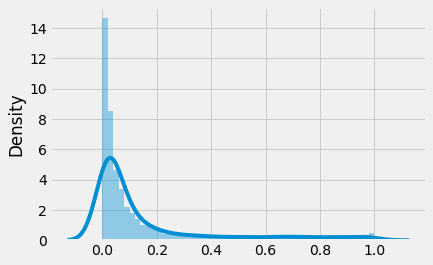

In [89]:
sns.distplot(test_preds1)
plt.show()

## LightGBM 피처 중요도 플롯

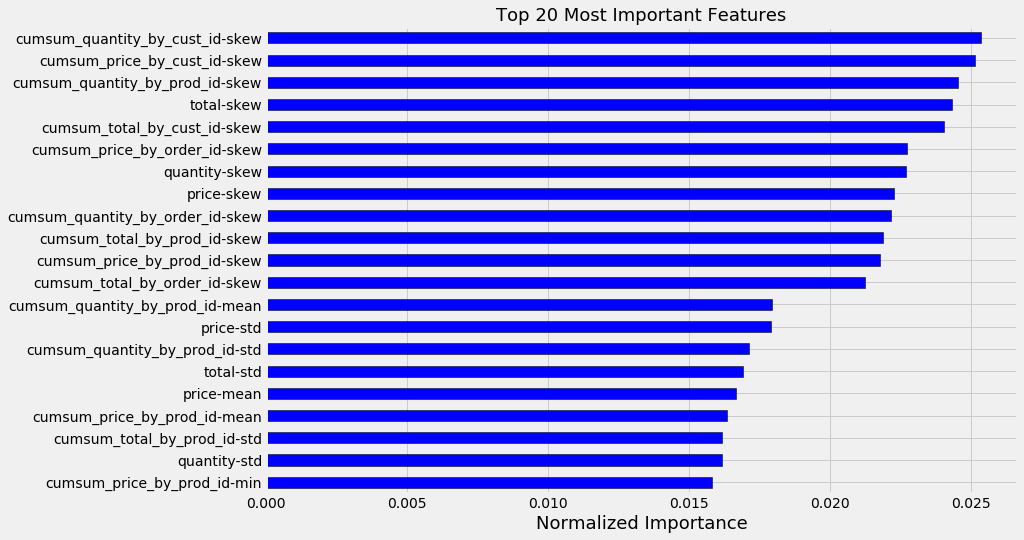

In [90]:
fi = plot_feature_importances(fi)

## XGBoost Hyperparameter 선언

In [91]:
xgb_params = {
    'objective': 'binary:logistic', # 이진 분류
    'learning_rate': 0.1, # 학습률
    'max_depth': 6, # 트리 최고 깊이
    'colsample_bytree': 0.8, # 피처 샘플링 비율
    'subsample': 0.8, # 데이터 샘플링 비율
    'eval_metric': 'auc', # 평가 지표 설정
    'seed': SEED,
} 

## 2011년 12월 XGBoost 베이스라인 모델 예측
- Validation 성능 측정

In [92]:
y_oof, test_preds2, fi_xgb = make_xgb_oof_prediction(all_train.reset_index(drop=True), all_y.reset_index(drop=True), test, train_features, model_params=xgb_params)

fold: 1, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)
[0]	train-auc:0.77427	valid-auc:0.77160
[200]	train-auc:0.90063	valid-auc:0.85536
[400]	train-auc:0.93351	valid-auc:0.87290
[600]	train-auc:0.94720	valid-auc:0.87971
[800]	train-auc:0.95440	valid-auc:0.88219
[1000]	train-auc:0.95828	valid-auc:0.88283
[1172]	train-auc:0.96042	valid-auc:0.88266
Fold 1 | AUC: 0.8826612943601226
--------------------------------------------------------------------------------
fold: 2, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)
[0]	train-auc:0.77395	valid-auc:0.76970
[200]	train-auc:0.90159	valid-auc:0.84966
[400]	train-auc:0.93500	valid-auc:0.86742
[600]	train-auc:0.94792	valid-auc:0.87380
[800]	train-auc:0.95468	valid-auc:0.87633
[1000]	train-auc:0.95885	valid-auc:0.87753
[1096]	train-auc:0.96026	valid-auc:0.87726
Fold 2 | AUC: 0.8772545242482446
--------------------------------------------------------------------------------
fold: 3, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)
[0]	

## 2011년 12월 XGBoost 베이스라인 모델 예측 데이터 분포

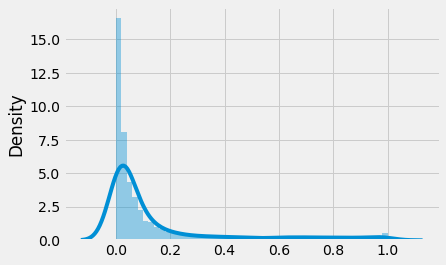

In [93]:
sns.distplot(test_preds2)
plt.show()

## XGBoost 피처 중요도 플롯

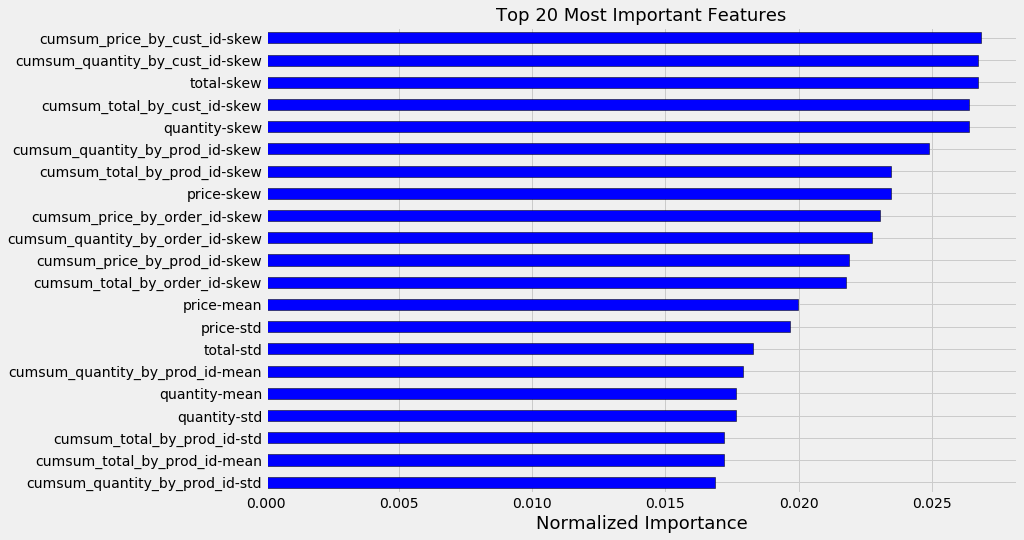

In [94]:
fi_xgb = plot_feature_importances(fi_xgb)

## CatBoost Hyperparameter 선언

In [95]:
cat_params = {
    'n_estimators': 10000, # 트리 개수
    'learning_rate': 0.07, # 학습률
    'eval_metric': 'AUC', # 평가 지표 설정
    'loss_function': 'Logloss', # 손실 함수 설정
    'random_seed': SEED,
    'metric_period': 100,
    'od_wait': 100, # early stopping round
    'depth': 6, # 트리 최고 깊이
    'rsm': 0.8, # 피처 샘플링 비율
}

## 2011년 12월 CatBoost 베이스라인 모델 예측
- Validation 성능 측정

In [96]:
y_oof, test_preds3, fi_cat = make_cat_oof_prediction(all_train.reset_index(drop=True), all_y.reset_index(drop=True), test, train_features, model_params=cat_params)

fold: 1, x_tr.shape: (123484, 86), x_val.shape: (13721, 86)


0:	test: 0.7414126	best: 0.7414126 (0)	total: 25ms	remaining: 4m 9s
100:	test: 0.7849140	best: 0.7849140 (100)	total: 2.33s	remaining: 3m 48s
200:	test: 0.7976325	best: 0.7976325 (200)	total: 4.61s	remaining: 3m 44s
300:	test: 0.8092442	best: 0.8092442 (300)	total: 6.85s	remaining: 3m 40s
400:	test: 0.8189557	best: 0.8189557 (400)	total: 9.06s	remaining: 3m 36s
500:	test: 0.8268622	best: 0.8268622 (500)	total: 11.3s	remaining: 3m 34s
600:	test: 0.8336857	best: 0.8336857 (600)	total: 13.5s	remaining: 3m 31s
700:	test: 0.8400636	best: 0.8400636 (700)	total: 15.8s	remaining: 3m 30s
800:	test: 0.8455382	best: 0.8455382 (800)	total: 18.1s	remaining: 3m 27s
900:	test: 0.8504061	best: 0.8504187 (899)	total: 20.3s	remaining: 3m 24s
1000:	test: 0.8538639	best: 0.8538639 (1000)	total: 22.6s	remaining: 3m 22s
1100:	test: 0.8573309	best: 0.8573309 (1100)	total: 24.8s	remaining: 3m 20s
1200:	test: 0.8595105	best: 0.8595105 (1200)	total: 27.1s	remaining: 3m 18s
1300:	test: 0.8620549	best: 0.8620583 

0:	test: 0.7395996	best: 0.7395996 (0)	total: 26ms	remaining: 4m 20s
100:	test: 0.7812793	best: 0.7812793 (100)	total: 2.35s	remaining: 3m 50s
200:	test: 0.7942740	best: 0.7942740 (200)	total: 4.6s	remaining: 3m 44s
300:	test: 0.8059103	best: 0.8059103 (300)	total: 6.91s	remaining: 3m 42s
400:	test: 0.8160497	best: 0.8160497 (400)	total: 9.18s	remaining: 3m 39s
500:	test: 0.8237878	best: 0.8237878 (500)	total: 11.4s	remaining: 3m 36s
600:	test: 0.8304292	best: 0.8304292 (600)	total: 13.7s	remaining: 3m 34s
700:	test: 0.8360593	best: 0.8360593 (700)	total: 16.1s	remaining: 3m 32s
800:	test: 0.8411612	best: 0.8411612 (800)	total: 18.3s	remaining: 3m 29s
900:	test: 0.8453948	best: 0.8454092 (899)	total: 20.6s	remaining: 3m 27s
1000:	test: 0.8493211	best: 0.8493211 (1000)	total: 22.8s	remaining: 3m 25s
1100:	test: 0.8524107	best: 0.8524107 (1100)	total: 25.1s	remaining: 3m 22s
1200:	test: 0.8556909	best: 0.8556909 (1200)	total: 27.3s	remaining: 3m 20s
1300:	test: 0.8580134	best: 0.8580134 

0:	test: 0.7380485	best: 0.7380485 (0)	total: 24.6ms	remaining: 4m 6s
100:	test: 0.7829905	best: 0.7829905 (100)	total: 2.29s	remaining: 3m 44s
200:	test: 0.7961592	best: 0.7961592 (200)	total: 4.61s	remaining: 3m 44s
300:	test: 0.8078314	best: 0.8078314 (300)	total: 6.96s	remaining: 3m 44s
400:	test: 0.8168049	best: 0.8168049 (400)	total: 9.22s	remaining: 3m 40s
500:	test: 0.8258316	best: 0.8258316 (500)	total: 11.5s	remaining: 3m 38s
600:	test: 0.8325221	best: 0.8325221 (600)	total: 13.8s	remaining: 3m 35s
700:	test: 0.8383987	best: 0.8383987 (700)	total: 16.1s	remaining: 3m 33s
800:	test: 0.8433944	best: 0.8433944 (800)	total: 18.4s	remaining: 3m 31s
900:	test: 0.8477985	best: 0.8478226 (897)	total: 20.8s	remaining: 3m 29s
1000:	test: 0.8523998	best: 0.8523998 (1000)	total: 23s	remaining: 3m 26s
1100:	test: 0.8554582	best: 0.8554582 (1100)	total: 25.3s	remaining: 3m 24s
1200:	test: 0.8584176	best: 0.8584176 (1200)	total: 27.6s	remaining: 3m 21s
1300:	test: 0.8611684	best: 0.8611684 

0:	test: 0.7368178	best: 0.7368178 (0)	total: 23.2ms	remaining: 3m 52s
100:	test: 0.7820207	best: 0.7820207 (100)	total: 2.32s	remaining: 3m 47s
200:	test: 0.7941767	best: 0.7941767 (200)	total: 4.65s	remaining: 3m 46s
300:	test: 0.8053275	best: 0.8053633 (299)	total: 6.88s	remaining: 3m 41s
400:	test: 0.8144021	best: 0.8144021 (400)	total: 9.15s	remaining: 3m 39s
500:	test: 0.8215062	best: 0.8215062 (500)	total: 11.3s	remaining: 3m 33s
600:	test: 0.8275961	best: 0.8275961 (600)	total: 13.3s	remaining: 3m 28s
700:	test: 0.8325090	best: 0.8325222 (699)	total: 15.5s	remaining: 3m 25s
800:	test: 0.8377087	best: 0.8377087 (800)	total: 17.6s	remaining: 3m 22s
900:	test: 0.8421867	best: 0.8421867 (900)	total: 19.7s	remaining: 3m 19s
1000:	test: 0.8464140	best: 0.8464140 (1000)	total: 21.8s	remaining: 3m 15s
1100:	test: 0.8496461	best: 0.8496461 (1100)	total: 24s	remaining: 3m 14s
1200:	test: 0.8528161	best: 0.8528161 (1200)	total: 26.2s	remaining: 3m 11s
1300:	test: 0.8556819	best: 0.8556819

0:	test: 0.7344328	best: 0.7344328 (0)	total: 39.4ms	remaining: 6m 33s
100:	test: 0.7767864	best: 0.7767864 (100)	total: 2.44s	remaining: 3m 58s
200:	test: 0.7893424	best: 0.7893424 (200)	total: 4.79s	remaining: 3m 53s
300:	test: 0.8013183	best: 0.8013183 (300)	total: 7.17s	remaining: 3m 50s
400:	test: 0.8112175	best: 0.8112175 (400)	total: 9.42s	remaining: 3m 45s
500:	test: 0.8194247	best: 0.8194247 (500)	total: 11.7s	remaining: 3m 41s
600:	test: 0.8264452	best: 0.8264452 (600)	total: 14s	remaining: 3m 38s
700:	test: 0.8321218	best: 0.8321218 (700)	total: 16.2s	remaining: 3m 34s
800:	test: 0.8374686	best: 0.8374686 (800)	total: 18.4s	remaining: 3m 31s
900:	test: 0.8421301	best: 0.8421301 (900)	total: 20.8s	remaining: 3m 30s
1000:	test: 0.8460312	best: 0.8460312 (1000)	total: 23.2s	remaining: 3m 28s
1100:	test: 0.8493977	best: 0.8493977 (1100)	total: 25.4s	remaining: 3m 25s
1200:	test: 0.8526916	best: 0.8526916 (1200)	total: 27.8s	remaining: 3m 23s
1300:	test: 0.8557449	best: 0.8557449

0:	test: 0.7460829	best: 0.7460829 (0)	total: 36.1ms	remaining: 6m 1s
100:	test: 0.7874911	best: 0.7874911 (100)	total: 2.27s	remaining: 3m 42s
200:	test: 0.7994449	best: 0.7994449 (200)	total: 4.5s	remaining: 3m 39s
300:	test: 0.8106471	best: 0.8106471 (300)	total: 6.73s	remaining: 3m 36s
400:	test: 0.8205931	best: 0.8205931 (400)	total: 8.98s	remaining: 3m 34s
500:	test: 0.8284681	best: 0.8284681 (500)	total: 11.3s	remaining: 3m 35s
600:	test: 0.8350038	best: 0.8350038 (600)	total: 13.6s	remaining: 3m 32s
700:	test: 0.8412469	best: 0.8412469 (700)	total: 15.8s	remaining: 3m 29s
800:	test: 0.8459478	best: 0.8459478 (800)	total: 18s	remaining: 3m 27s
900:	test: 0.8500357	best: 0.8500357 (900)	total: 20.3s	remaining: 3m 25s
1000:	test: 0.8532664	best: 0.8532664 (1000)	total: 22.6s	remaining: 3m 23s
1100:	test: 0.8567471	best: 0.8567471 (1100)	total: 24.9s	remaining: 3m 21s
1200:	test: 0.8598921	best: 0.8598921 (1200)	total: 27.2s	remaining: 3m 19s
1300:	test: 0.8630060	best: 0.8630060 (

0:	test: 0.7382569	best: 0.7382569 (0)	total: 25.2ms	remaining: 4m 11s
100:	test: 0.7787943	best: 0.7787943 (100)	total: 2.46s	remaining: 4m 1s
200:	test: 0.7912292	best: 0.7912292 (200)	total: 4.8s	remaining: 3m 54s
300:	test: 0.8027611	best: 0.8027611 (300)	total: 7.04s	remaining: 3m 46s
400:	test: 0.8129787	best: 0.8129787 (400)	total: 9.38s	remaining: 3m 44s
500:	test: 0.8215009	best: 0.8215009 (500)	total: 11.6s	remaining: 3m 40s
600:	test: 0.8288971	best: 0.8288971 (600)	total: 13.9s	remaining: 3m 37s
700:	test: 0.8350991	best: 0.8350991 (700)	total: 16.4s	remaining: 3m 37s
800:	test: 0.8402810	best: 0.8402810 (800)	total: 18.7s	remaining: 3m 35s
900:	test: 0.8450255	best: 0.8450255 (900)	total: 21.1s	remaining: 3m 32s
1000:	test: 0.8493778	best: 0.8493840 (999)	total: 23.4s	remaining: 3m 30s
1100:	test: 0.8531123	best: 0.8531123 (1100)	total: 25.8s	remaining: 3m 28s
1200:	test: 0.8567971	best: 0.8567971 (1200)	total: 28.1s	remaining: 3m 25s
1300:	test: 0.8600957	best: 0.8600957 

0:	test: 0.7400837	best: 0.7400837 (0)	total: 24.1ms	remaining: 4m 1s
100:	test: 0.7811920	best: 0.7811920 (100)	total: 2.29s	remaining: 3m 44s
200:	test: 0.7932149	best: 0.7932149 (200)	total: 4.5s	remaining: 3m 39s
300:	test: 0.8053769	best: 0.8053769 (300)	total: 6.82s	remaining: 3m 39s
400:	test: 0.8147348	best: 0.8147348 (400)	total: 9.07s	remaining: 3m 37s
500:	test: 0.8234242	best: 0.8234242 (500)	total: 11.4s	remaining: 3m 35s
600:	test: 0.8304404	best: 0.8304404 (600)	total: 13.7s	remaining: 3m 33s
700:	test: 0.8363863	best: 0.8363863 (700)	total: 15.9s	remaining: 3m 30s
800:	test: 0.8420134	best: 0.8420134 (800)	total: 18.1s	remaining: 3m 28s
900:	test: 0.8469670	best: 0.8469670 (900)	total: 20.4s	remaining: 3m 25s
1000:	test: 0.8507959	best: 0.8507959 (1000)	total: 22.6s	remaining: 3m 23s
1100:	test: 0.8545179	best: 0.8545179 (1100)	total: 24.9s	remaining: 3m 20s
1200:	test: 0.8576141	best: 0.8576141 (1200)	total: 27.1s	remaining: 3m 18s
1300:	test: 0.8606407	best: 0.8606504

0:	test: 0.7409523	best: 0.7409523 (0)	total: 24.1ms	remaining: 4m 1s
100:	test: 0.7821122	best: 0.7821122 (100)	total: 2.28s	remaining: 3m 43s
200:	test: 0.7949595	best: 0.7949595 (200)	total: 4.49s	remaining: 3m 38s
300:	test: 0.8073678	best: 0.8073678 (300)	total: 6.72s	remaining: 3m 36s
400:	test: 0.8160903	best: 0.8160903 (400)	total: 8.99s	remaining: 3m 35s
500:	test: 0.8239892	best: 0.8239892 (500)	total: 11.2s	remaining: 3m 33s
600:	test: 0.8305326	best: 0.8305326 (600)	total: 13.5s	remaining: 3m 30s
700:	test: 0.8362725	best: 0.8362725 (700)	total: 15.8s	remaining: 3m 29s
800:	test: 0.8411860	best: 0.8411860 (800)	total: 18s	remaining: 3m 26s
900:	test: 0.8459725	best: 0.8459857 (899)	total: 20.3s	remaining: 3m 24s
1000:	test: 0.8503227	best: 0.8503227 (1000)	total: 22.6s	remaining: 3m 22s
1100:	test: 0.8541540	best: 0.8541540 (1100)	total: 24.9s	remaining: 3m 21s
1200:	test: 0.8570879	best: 0.8570879 (1200)	total: 27.2s	remaining: 3m 19s
1300:	test: 0.8597229	best: 0.8597253 

0:	test: 0.7442440	best: 0.7442440 (0)	total: 23.7ms	remaining: 3m 57s
100:	test: 0.7885065	best: 0.7885065 (100)	total: 2.27s	remaining: 3m 42s
200:	test: 0.7990314	best: 0.7990314 (200)	total: 4.5s	remaining: 3m 39s
300:	test: 0.8103061	best: 0.8103061 (300)	total: 6.72s	remaining: 3m 36s
400:	test: 0.8182966	best: 0.8182966 (400)	total: 8.98s	remaining: 3m 35s
500:	test: 0.8267343	best: 0.8267343 (500)	total: 11.2s	remaining: 3m 33s
600:	test: 0.8326267	best: 0.8326267 (600)	total: 13.5s	remaining: 3m 30s
700:	test: 0.8377339	best: 0.8377339 (700)	total: 15.7s	remaining: 3m 28s
800:	test: 0.8435019	best: 0.8435019 (800)	total: 18s	remaining: 3m 26s
900:	test: 0.8473681	best: 0.8473681 (900)	total: 20.2s	remaining: 3m 23s
1000:	test: 0.8508965	best: 0.8509304 (999)	total: 22.4s	remaining: 3m 21s
1100:	test: 0.8547800	best: 0.8547800 (1100)	total: 24.6s	remaining: 3m 19s
1200:	test: 0.8581522	best: 0.8581522 (1200)	total: 27s	remaining: 3m 17s
1300:	test: 0.8608175	best: 0.8608276 (12

## 2011년 12월 CatBoost 베이스라인 모델 예측 데이터 분포

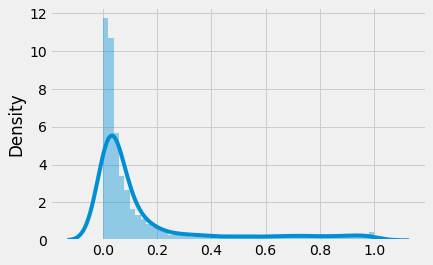

In [97]:
sns.distplot(test_preds3)
plt.show()

## CatBoost 피처 중요도 플롯

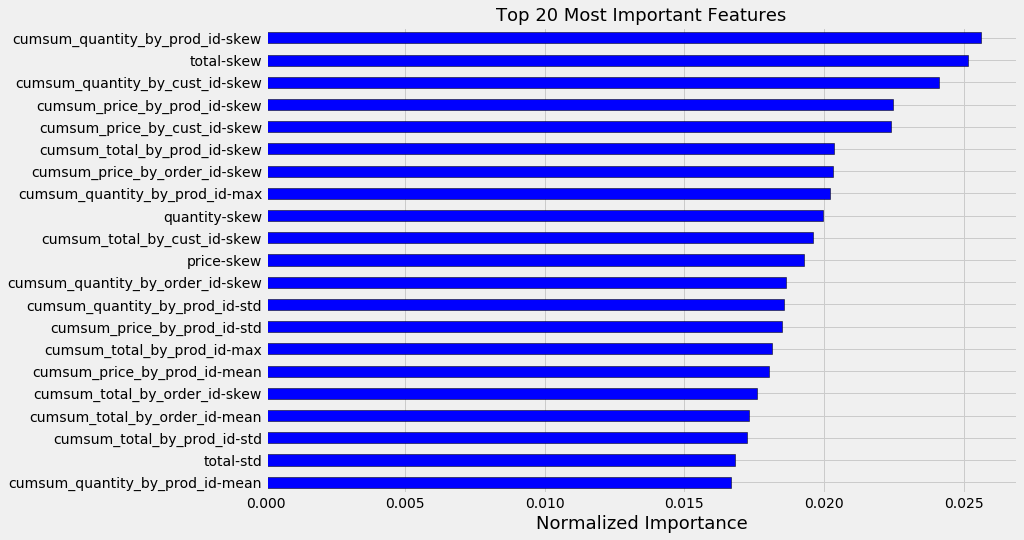

In [98]:
fi_cat = plot_feature_importances(fi_cat)

In [99]:
print(test_preds1[1])
print(test_preds2[1])
print(test_preds3[1])

0.09391305907904715
0.03789936099201441
0.05455785512579847


In [100]:
preds = []
for i in range(len(test_preds1)):
    a = (0.3*test_preds1[i]) + (0.4*test_preds2[i]) + (0.3*test_preds3[i])
    preds.append(a)
    a = 0
    
final_preds = np.array(preds)

In [101]:
print(final_preds[1])


0.05970101865825945


In [102]:
output_dir = '../output'
os.makedirs(output_dir, exist_ok=True)
submission = pd.read_csv('../input/sample_submission.csv')
submission['probability'] = final_preds
submission.to_csv(os.path.join(output_dir, 'output.csv'), index=False)